In [ ]:
# Core Python & Utilities
from itertools import product
from tqdm import tqdm

# Data Handling
import numpy as np
import pandas as pd

# Stats & Modeling
import math
from scipy.optimize import least_squares
from scipy.stats import sem, t

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Preferences
pd.set_option("display.max_columns", None)

# A Range of Concurrent VRs

In [2]:
# --- MPR Model Equations ---
def update_arousal(prev_arousal: float, reinforcement: int, alpha: float, a: float) -> float:
    """Update arousal based on previous value and new reinforcement event"""
    return alpha * (a * reinforcement) + (1 - alpha) * prev_arousal

def compute_total_response_rate(A: float, delta: float) -> float:
    """Compute total response rate given arousal and motor constraint"""
    return (1 / delta) * (A / (1 + A))

def compute_target_response_rate(A: float, delta: float, coupling: float) -> float:
    """Compute target response rate based on arousal and coupling"""
    return coupling * (1 / delta) * (A / (1 + A))

def compute_c_star_vr(schedule_param, lambda_=0.3):
    """Compute schedule-sensitive coupling asymptote for VR schedule."""
    return 1 - math.exp(-lambda_ * schedule_param)

def update_coupling(prev_coupling: float, c_star: float, learning_rate: float) -> float:
    """Recursive update toward C*."""
    return prev_coupling + learning_rate * (c_star - prev_coupling)

def update_step(prev_arousal, prev_coupling, reinforcement, a, delta, alpha=0.1, eta=0.05,
                schedule_param=1.0, lambda_=0.3):
    """Update arousal and schedule-sensitive coupling for VR schedules."""
    A = update_arousal(prev_arousal, reinforcement, alpha, a)
    C_star = compute_c_star_vr(schedule_param=schedule_param, lambda_=lambda_)
    C = update_coupling(prev_coupling, c_star=C_star, learning_rate=eta)
    b_total = compute_total_response_rate(A, delta)
    b_target = compute_target_response_rate(A, delta, C)
    return A, C, b_total, b_target

# --- CI Helper ---
def ci95(data):
    n = len(data)
    return sem(data) * t.ppf(0.975, n - 1)

# --- Simulation with Persistent State Across Concurrent VR Pairs ---
def simulate_concurrent_mpr_sequence(vr_pairs, a, delta, alpha, eta, ao_id, num_steps=1000, lambda_=0.3, cod_duration=6):
    A1, C1 = 0.6, 0.5
    A2, C2 = 0.6, 0.5
    all_results = []

    for pair_index, (vr1, vr2) in enumerate(vr_pairs):
        A1_hist, A2_hist = [], []
        C1_hist, C2_hist = [], []
        b1_hist, b2_hist = [], []

        # COD tracking
        last_choice = None
        steps_since_switch = cod_duration  # start eligible

        for _ in range(num_steps):
            # Choice rule
            p1 = C1 / (C1 + C2)
            choice = np.random.choice([1, 2], p=[p1, 1 - p1])

            # Detect switch
            if choice != last_choice:
                steps_since_switch = 0
                last_choice = choice
            else:
                steps_since_switch += 1

            # Simulate schedule availability
            r1 = int(np.random.rand() < (1 / vr1))
            r2 = int(np.random.rand() < (1 / vr2))

            # Determine eligibility based on COD
            eligible = steps_since_switch >= cod_duration
            reinforce1 = r1 if (choice == 1 and eligible) else 0
            reinforce2 = r2 if (choice == 2 and eligible) else 0

            # Update model
            if choice == 1:
                A1, C1, _, _ = update_step(A1, C1, reinforce1, a, delta, alpha, eta, schedule_param=vr1, lambda_=lambda_)
                A2 = update_arousal(A2, 0, alpha, a)
                C2_star = 1 - np.exp(-lambda_ * vr2)
                C2 = update_coupling(C2, C2_star, learning_rate=eta)
                b1_hist.append(1)
                b2_hist.append(0)
            else:
                A2, C2, _, _ = update_step(A2, C2, reinforce2, a, delta, alpha, eta, schedule_param=vr2, lambda_=lambda_)
                A1 = update_arousal(A1, 0, alpha, a)
                C1_star = 1 - np.exp(-lambda_ * vr1)
                C1 = update_coupling(C1, C1_star, learning_rate=eta)
                b1_hist.append(0)
                b2_hist.append(1)

            A1_hist.append(A1)
            A2_hist.append(A2)
            C1_hist.append(C1)
            C2_hist.append(C2)

        def ci95(data):
            return sem(data) * t.ppf(0.975, len(data) - 1)

        all_results.append({
            'AO_id': ao_id,
            'pair_index': pair_index,
            'VR1': vr1,
            'VR2': vr2,
            'reinforcement_ratio': np.round(vr2 / vr1, 2),
            'arousal1_avg': np.mean(A1_hist),
            'arousal2_avg': np.mean(A2_hist),
            'coupling1_avg': np.mean(C1_hist),
            'coupling2_avg': np.mean(C2_hist),
            'choice1_avg': np.mean(b1_hist),
            'choice2_avg': np.mean(b2_hist),
            'arousal1_ci': ci95(A1_hist),
            'arousal2_ci': ci95(A2_hist),
            'coupling1_ci': ci95(C1_hist),
            'coupling2_ci': ci95(C2_hist),
            'choice1_ci': ci95(b1_hist),
            'choice2_ci': ci95(b2_hist),
            'activation': a,
            'delta': delta,
            'alpha': alpha,
            'eta': eta,
            'COD_steps': cod_duration
        })

    return all_results


# Parameter Grid
deltas = [0.25, 0.50, 1.0, 2.0]
activations = [0.1, 0.2, 0.4, 0.8, 1.6]
alphas = [0.01, 0.03, 0.1, 0.3, 1.0]
etas = [0.01, 0.03, 0.3, 1.0]
vr_pairs = [(1, 9), (1, 3), (2, 2), (3, 1), (9, 1)]  # all pairs to be run per AO

# Run each AO through all VR pairs
concurrent_results = []
grid = list(product(activations, deltas, alphas, etas))

for ao_id, (a, delta, alpha, eta) in enumerate(tqdm(grid, desc="Running concurrent VR AOs")):
    sim_result_list = simulate_concurrent_mpr_sequence(vr_pairs, a, delta, alpha, eta, ao_id=ao_id)
    concurrent_results.extend(sim_result_list)

# Final DataFrame
results_concurrent_df = pd.DataFrame(concurrent_results)

Running concurrent VR AOs:   0%|          | 0/400 [00:00<?, ?it/s]

Running concurrent VR AOs: 100%|██████████| 400/400 [01:07<00:00,  5.96it/s]


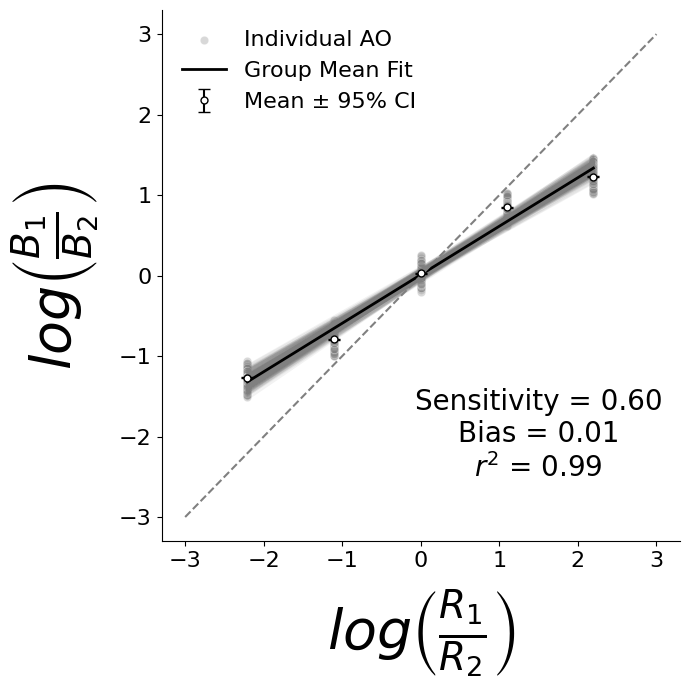

In [3]:
# Prep data
results_concurrent_df['response_ratio'] = results_concurrent_df['choice2_avg'] / results_concurrent_df['choice1_avg']
results_concurrent_df['log_resp_ratio'] = np.log(results_concurrent_df['response_ratio'])
results_concurrent_df['log_reinf_ratio'] = np.log(results_concurrent_df['reinforcement_ratio'])

# Fit matching law to each AO
ao_fits = []
ao_lines = []

for ao_id, group in results_concurrent_df.groupby("AO_id"):
    if group['log_reinf_ratio'].nunique() < 2:
        continue
    X = group[['log_reinf_ratio']]
    y = group['log_resp_ratio']
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, model.predict(X))

    ao_fits.append({
        'AO_id': ao_id,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r2
    })

    # Store line for plotting
    x_range = np.linspace(X.min(), X.max(), 100)
    ao_lines.append(pd.DataFrame({
        'AO_id': ao_id,
        'x': x_range.squeeze(),
        'y': model.predict(pd.DataFrame({'log_reinf_ratio': x_range.squeeze()}))
    }))

fit_df = pd.DataFrame(ao_fits)
ao_lines_df = pd.concat(ao_lines)

# Aggregate means across AOs per VR pair
grouped_means = results_concurrent_df.groupby(['VR1', 'VR2', 'reinforcement_ratio']).agg(
    log_resp_ratio_mean=('log_resp_ratio', 'mean'),
    log_resp_ratio_se=('log_resp_ratio', sem),
    log_reinf_ratio=('log_reinf_ratio', 'mean')
).reset_index()

grouped_means['log_resp_ratio_ci'] = grouped_means['log_resp_ratio_se'] * t.ppf(0.975, df=len(results_concurrent_df) - 1)

# Fit matching law to group means
X_group = grouped_means[['log_reinf_ratio']]
y_group = grouped_means['log_resp_ratio_mean']

group_model = LinearRegression().fit(X_group, y_group)
group_slope = group_model.coef_[0]
group_intercept = group_model.intercept_
group_r2 = r2_score(y_group, group_model.predict(X_group))

x_range_group = np.linspace(X_group.min(), X_group.max(), 100)
y_pred_group = group_model.predict(pd.DataFrame({'log_reinf_ratio': x_range_group.squeeze()}))

# Plot everything
plt.figure(figsize=(7, 7))

# Gray points and individual AO fits
sns.scatterplot(
    x='log_reinf_ratio',
    y='log_resp_ratio',
    data=results_concurrent_df,
    color='gray',
    alpha=0.3,
    label='Individual AO'
)

for _, ao_line in ao_lines_df.groupby('AO_id'):
    plt.plot(ao_line['x'], ao_line['y'], color='gray', alpha=0.1)

# Mean ± 95% CI
plt.errorbar(
    x=grouped_means['log_reinf_ratio'],
    y=grouped_means['log_resp_ratio_mean'],
    yerr=grouped_means['log_resp_ratio_ci'],
    fmt='o',
    color='white',
    markersize=5,
    elinewidth=1.5,
    ecolor='black',
    capsize=4,
    markeredgecolor='black',
    label='Mean ± 95% CI'
)

# Group fit
plt.plot(x_range_group, y_pred_group, color='black', linewidth=2, label='Group Mean Fit')

# Identity line
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray')

# Labels and annotation
plt.xlabel(r'$\mathit{log}\left(\frac{R_1}{R_2}\right)$', fontsize=40, labelpad=12)
plt.ylabel(r'$\mathit{log}\left(\frac{B_1}{B_2}\right)$', fontsize=40, labelpad=12)

plt.text(
    1.5, -2.5,
    f"Sensitivity = {group_slope:.2f}\nBias = {group_intercept:.2f}\n$r^2$ = {group_r2:.2f}",
    fontsize=20,
    ha='center'
)

plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_17369/4147746324.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')


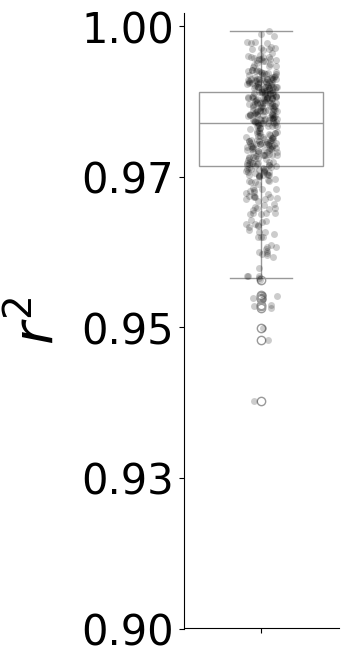

count    400.000000
mean       0.981885
std        0.009962
min        0.937813
25%        0.976753
50%        0.983961
75%        0.989154
max        0.999229
Name: r_squared, dtype: float64

In [4]:
fig, ax = plt.subplots(figsize=(2, 8))
sns.stripplot(fit_df['r_squared'], color='k', alpha=0.2)
sns.boxplot(fit_df['r_squared'], color='w', linecolor='gray')
sns.despine(top=True, right=True)
plt.ylabel(r"$r^2$", fontsize=40, labelpad=12)
plt.yticks(ticks=[0.9, 0.925, 0.95, 0.975, 1.0], fontsize=30)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
# plt.ylim(0.8, 1)
plt.show()
fit_df['r_squared'].describe()

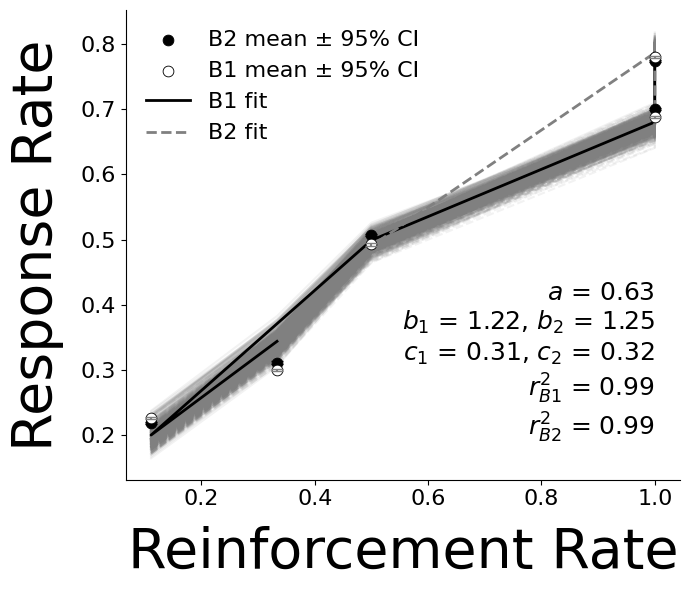

In [5]:
# Define McDowell concurrent schedule equations
def B1_eq(r1, r2, a, b1, c1, c2):
    return (b1 * (r1 ** a)) / (r1 ** a + (c1 / c2) * (r2 ** a) + c1)

def B2_eq(r1, r2, a, b2, c1, c2):
    return (b2 * (r2 ** a)) / ((c2 / c1) * (r1 ** a) + (r2 ** a) + c2)

# Joint residual function for least squares
def joint_residuals(params, r1, r2, B1_obs, B2_obs):
    a, b1, b2, c1, c2 = params
    B1_pred = B1_eq(r1, r2, a, b1, c1, c2)
    B2_pred = B2_eq(r1, r2, a, b2, c1, c2)
    return np.concatenate([(B1_pred - B1_obs), (B2_pred - B2_obs)])

# Prepare data
results_df = results_concurrent_df.copy()
results_df['r1'] = 1 / results_df['VR1']
results_df['r2'] = 1 / results_df['VR2']

# Fit per AO
fit_results = []
ao_fits = []

for ao_id, group in results_df.groupby("AO_id"):
    if group.shape[0] < 5:
        continue
    try:
        x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
        res = least_squares(
            joint_residuals,
            x0=x0,
            bounds=(0, np.inf),
            args=(group['r1'].values, group['r2'].values, group['choice2_avg'].values, group['choice1_avg'].values)
        )
        a, b1, b2, c1, c2 = res.x

        # Compute predictions and R²
        B1_pred = B1_eq(group['r1'], group['r2'], a, b1, c1, c2)
        B2_pred = B2_eq(group['r1'], group['r2'], a, b2, c1, c2)
        r2_B1 = r2_score(group['choice1_avg'], B1_pred)
        r2_B2 = r2_score(group['choice2_avg'], B2_pred)

        fit_results.append({
            'AO_id': ao_id,
            'a': a, 'b1': b1, 'b2': b2, 'c1': c1, 'c2': c2,
            'r2_B1': r2_B1, 'r2_B2': r2_B2
        })

        ao_fits.append({
            'AO_id': ao_id,
            'r1': group['r1'].values,
            'r2': group['r2'].values,
            'B1_pred': B1_pred,
            'B2_pred': B2_pred
        })
    except:
        continue

fit_df = pd.DataFrame(fit_results)

# Group means and CI
grouped = results_df.groupby(['VR1', 'VR2']).agg({
    'r1': 'mean',
    'r2': 'mean',
    'choice1_avg': ['mean', sem],
    'choice2_avg': ['mean', sem]
}).reset_index()

grouped.columns = ['VR1', 'VR2', 'r1', 'r2', 'B1_mean', 'B1_se', 'B2_mean', 'B2_se']
grouped['B1_ci'] = grouped['B1_se'] * t.ppf(0.975, df=len(results_df) - 1)
grouped['B2_ci'] = grouped['B2_se'] * t.ppf(0.975, df=len(results_df) - 1)

# Fit model to group means
x0 = [1.0, 1.0, 1.0, 0.1, 0.1]
res = least_squares(
    joint_residuals,
    x0=x0,
    bounds=(0, np.inf),
    args=(grouped['r1'].values, grouped['r2'].values, grouped['B2_mean'].values, grouped['B1_mean'].values)
)
a, b1, b2, c1, c2 = res.x

grouped['B1_pred'] = B1_eq(grouped['r2'], grouped['r1'], a, b1, c1, c2)
grouped['B2_pred'] = B2_eq(grouped['r2'], grouped['r1'], a, b2, c1, c2)

r2_B1 = r2_score(grouped['B1_mean'], grouped['B1_pred'])
r2_B2 = r2_score(grouped['B2_mean'], grouped['B2_pred'])

# Plot
plt.figure(figsize=(7, 6))

# All AO lines in gray
for fit in ao_fits:
    plt.plot(fit['r1'], fit['B1_pred'], color='gray', alpha=0.1, zorder=1)
    plt.plot(fit['r2'], fit['B2_pred'], color='gray', alpha=0.1, linestyle='--', zorder=1)

# Mean data points with CI
sns.scatterplot(x=grouped['r1'], y=grouped['B2_mean'], color='black', edgecolor='black', s=60,
                label='B2 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r1'], grouped['B2_mean'], yerr=grouped['B2_ci'], fmt='none',
             ecolor='black', capsize=4, zorder=10)

sns.scatterplot(x=grouped['r2'], y=grouped['B1_mean'], color='white', edgecolor='black', s=60,
                label='B1 mean ± 95% CI', zorder=10)
plt.errorbar(grouped['r2'], grouped['B1_mean'], yerr=grouped['B1_ci'], fmt='none',
             ecolor='gray', capsize=4, zorder=10)

# Group fits in bold
plt.plot(grouped['r2'], grouped['B1_pred'], color='black', linewidth=2,
         label='B1 fit', zorder=9)
plt.plot(grouped['r1'], grouped['B2_pred'], color='gray', linewidth=2, linestyle='--',
         label='B2 fit', zorder=9)

# Annotation
plt.text(
    1, 0.2,
    f"$a$ = {a:.2f}\n"
    f"$b_1$ = {b1:.2f}, $b_2$ = {b2:.2f}\n"
    f"$c_1$ = {c1:.2f}, $c_2$ = {c2:.2f}\n"
    f"$r^2_{{B1}}$ = {r2_B1:.2f}\n"
    f"$r^2_{{B2}}$ = {r2_B2:.2f}",
    fontsize=18,
    ha='right'
)

plt.xlabel('Reinforcement Rate', fontsize=40, labelpad=12)
plt.ylabel('Response Rate', fontsize=40, labelpad=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(frameon=False, fontsize=16)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


In [6]:
# Prepare data for concurrent schedule version of the same 4x4 grid plot
params = ['activation', 'delta', 'alpha', 'eta']

# Mapping for each lever's metrics
metrics_concurrent_1 = {
    'arousal1_avg': (r'Arousal ($\it{B}_{1}$)', 'arousal1_ci'),
    'coupling1_avg': (r'Coupling ($\it{B}_{1}$)', 'coupling1_ci'),
    'choice1_avg': (r'Choice Rate ($\it{B}_{1}$)', 'choice1_ci'),
}

metrics_concurrent_2 = {
    'arousal2_avg': (r'Arousal ($\it{B}_{2}$)', 'arousal2_ci'),
    'coupling2_avg': (r'Coupling ($\it{B}_{2}$)', 'coupling2_ci'),
    'choice2_avg': (r'Choice Rate ($\it{B}_{2}$)', 'choice2_ci'),
}

In [7]:
# Create subplot function
def plot_concurrent_grid(df, metrics, title):
    fig, axs = plt.subplots(3, 4, figsize=(16, 14), sharex='col', sharey=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for row_idx, (metric_col, (metric_label, ci_col)) in enumerate(metrics.items()):
        for col_idx, param in enumerate(params):
            ax = axs[row_idx, col_idx]
            if metric_col == '':  # Skip empty row
                ax.axis('off')
                continue

            sub_df = df[[param, metric_col, ci_col]].copy()
            sub_df['x_val'] = pd.Categorical(sub_df[param]).codes
            x_jittered = sub_df['x_val'] + np.random.uniform(-0.2, 0.2, size=len(sub_df))

            ax.scatter(x_jittered, sub_df[metric_col], color='black', alpha=0.7, s=15, zorder=2)
            ax.errorbar(
                x_jittered,
                sub_df[metric_col],
                yerr=sub_df[ci_col],
                fmt='none',
                ecolor='gray',
                elinewidth=0.8,
                capsize=2,
                alpha=0.6,
                zorder=1
            )

            # Add symbolic labels
            param_symbols = {
                'activation': 'Activation',
                'delta': r'$\delta$',
                'alpha': r'$\alpha$',
                'eta': r'$\eta$'
            }

            # Format axes
            if row_idx == 2:
                ax.set_xlabel(param_symbols[param], fontsize=20, labelpad=8, color='k')
                ax.set_xticks(range(len(sub_df[param].unique())))
                ax.set_xticklabels(sorted(sub_df[param].unique()), fontsize=10, color='k')
            else:
                ax.set_xlabel("")
                ax.set_xticklabels([])
                ax.tick_params(labelbottom=False)

            if col_idx == 0:
                ax.set_ylabel(metric_label, fontsize=20, labelpad=8, color='k')
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])

            ax.grid(False)
            sns.despine(top=True, right=True)

    plt.suptitle(title, fontsize=30)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



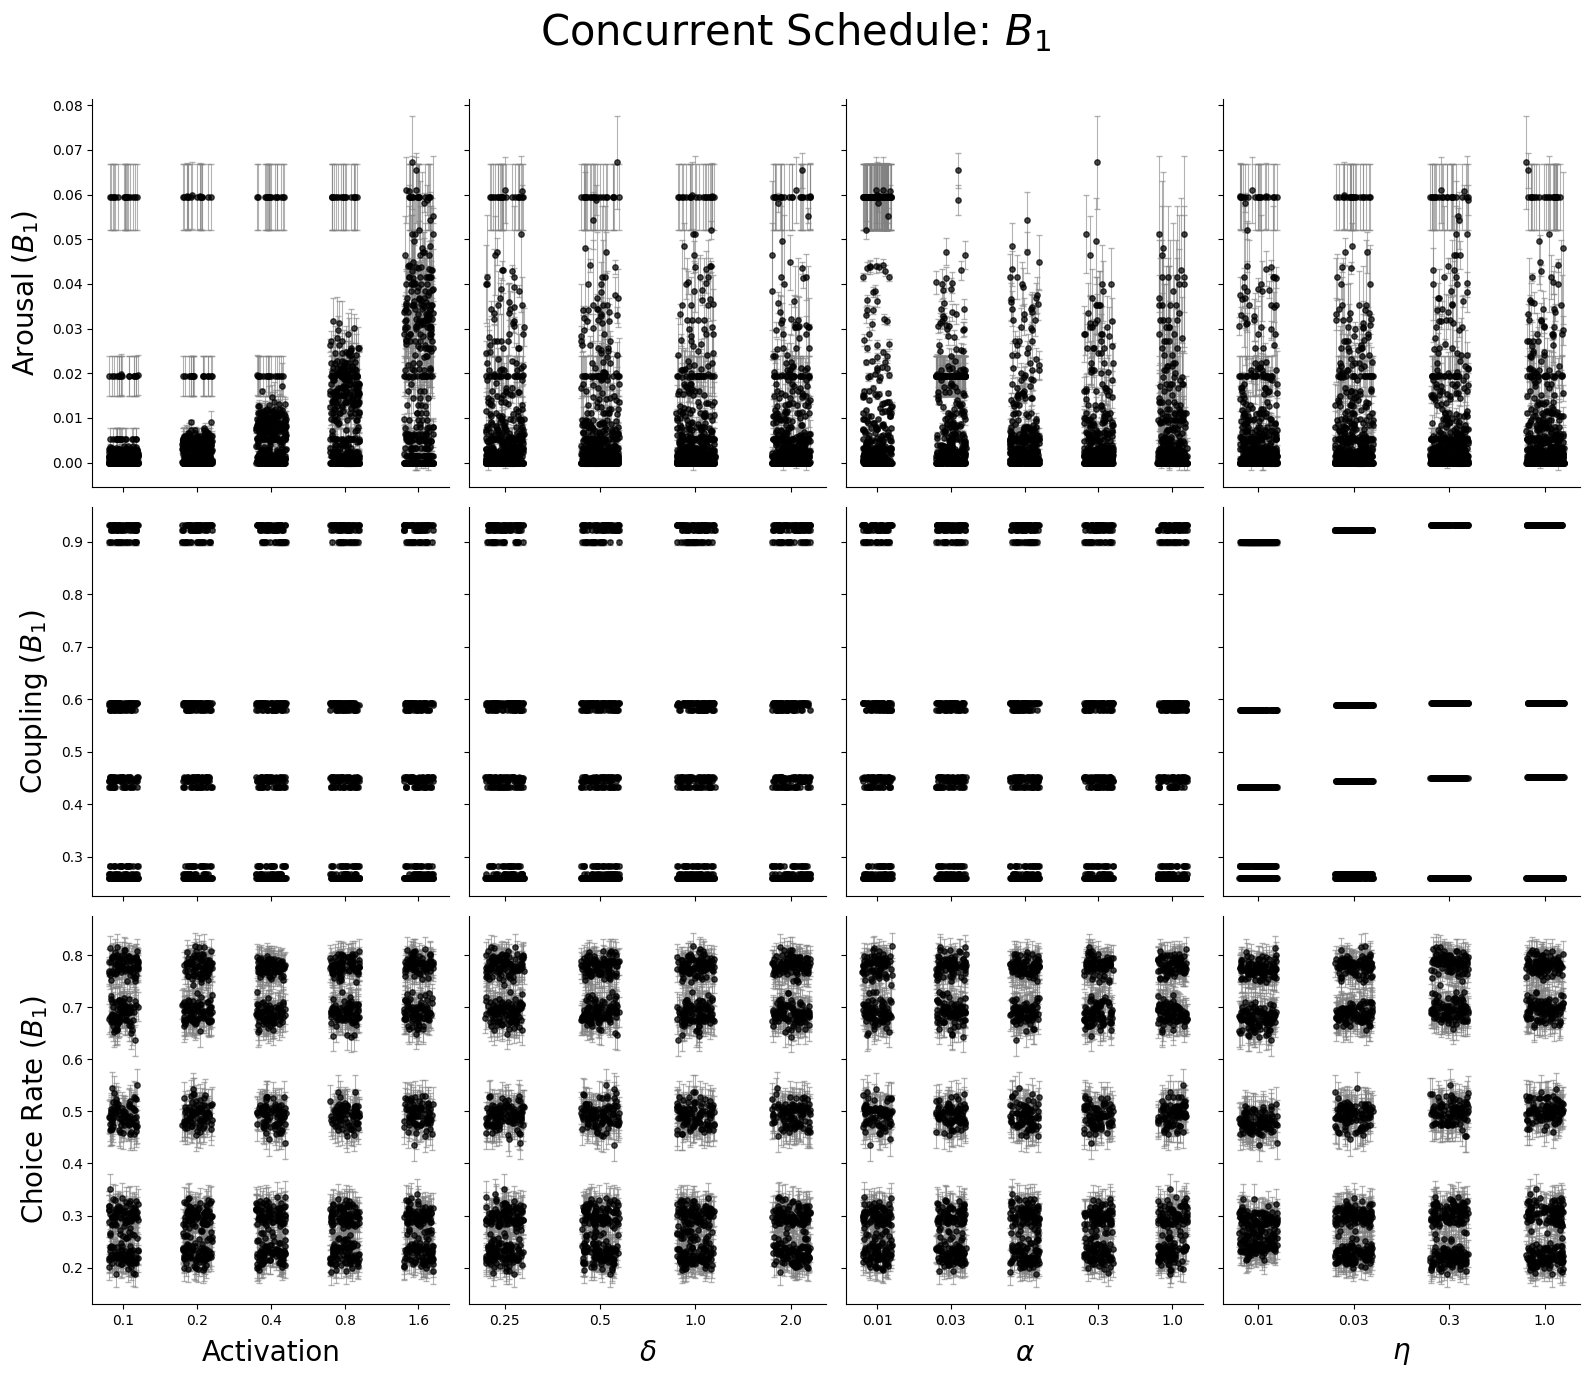

In [8]:
# Plot Lever 1
plot_concurrent_grid(results_concurrent_df, metrics_concurrent_1, r"Concurrent Schedule: $\it{B}_{1}$")

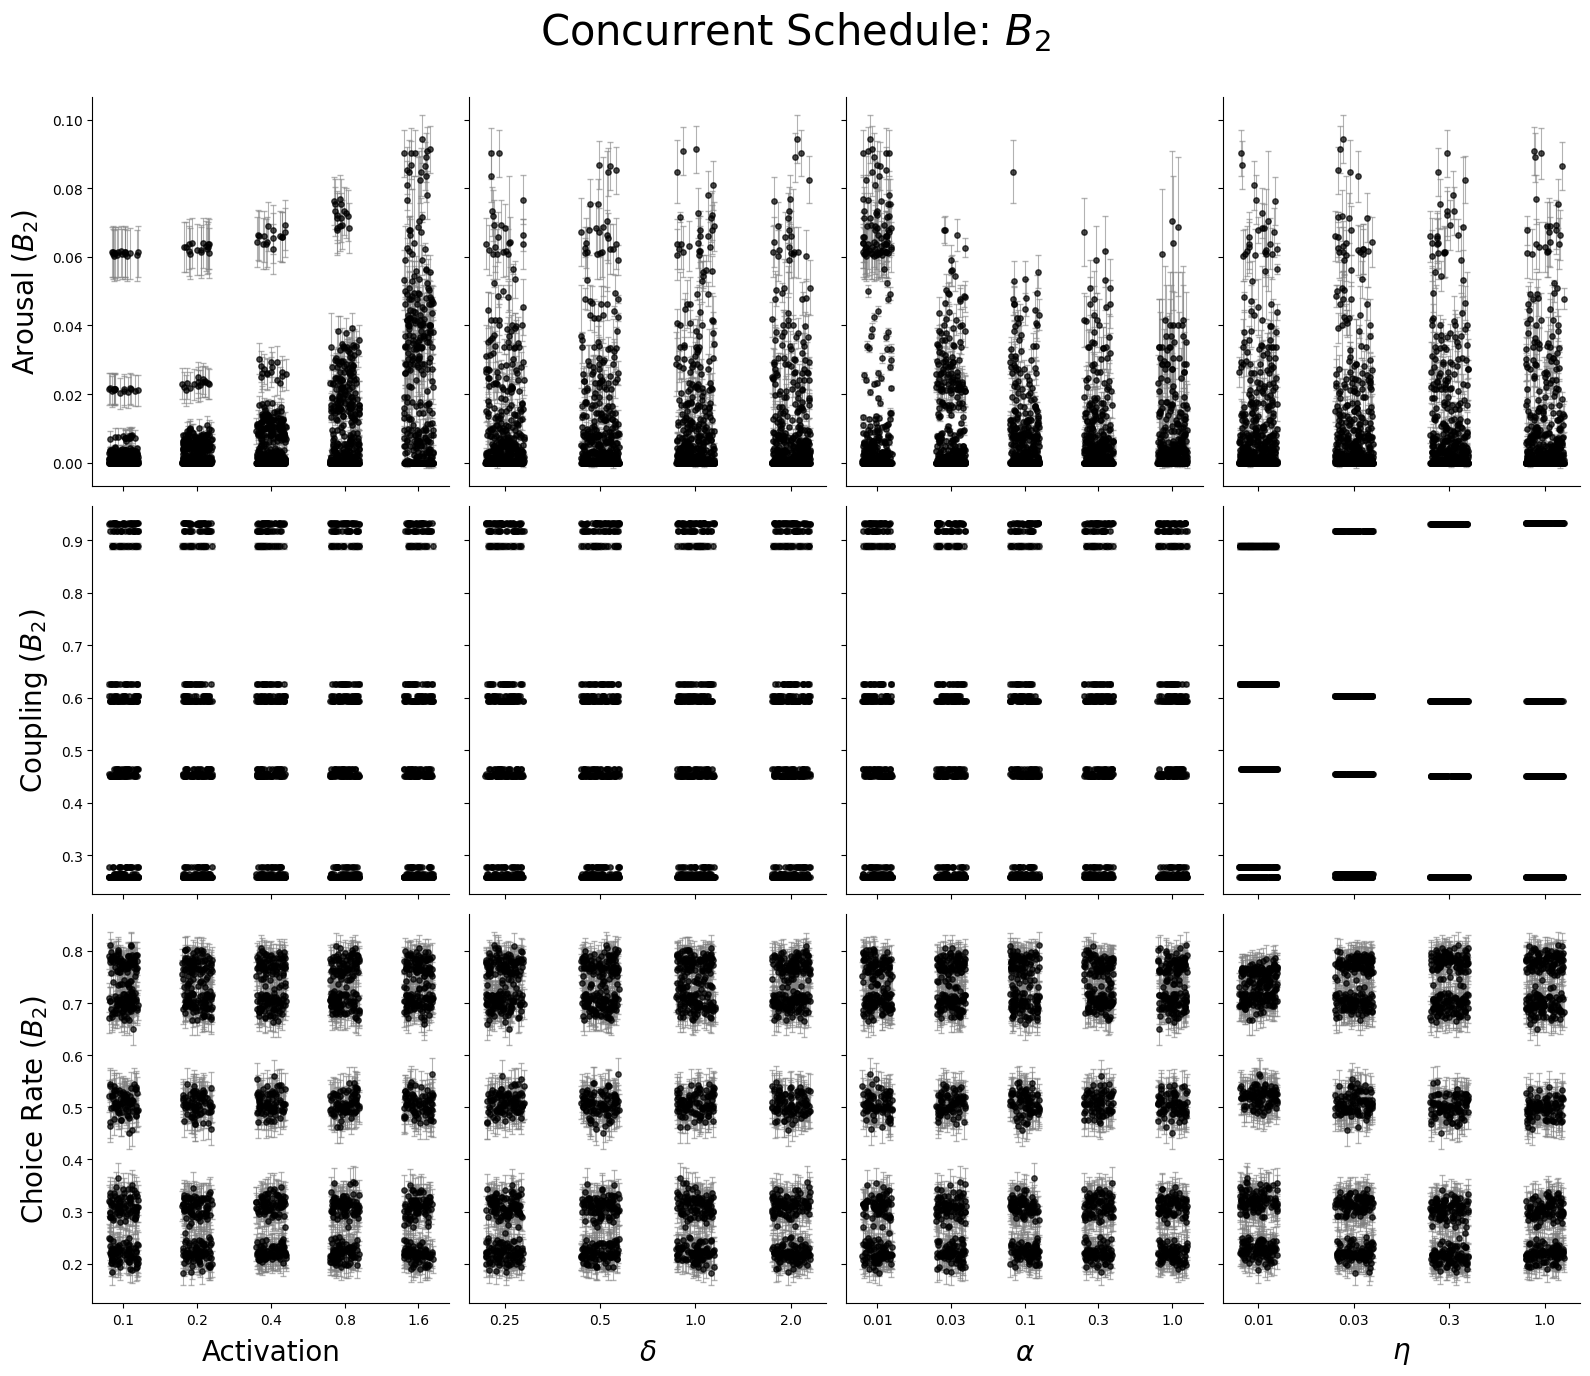

In [9]:
# Plot Lever 2
plot_concurrent_grid(results_concurrent_df, metrics_concurrent_2, r"Concurrent Schedule: $\it{B}_{2}$")